# Lab 4

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.signal
import seaborn as sns

from IPython.display import display, Math
from functools import partial
from scipy import optimize, stats
from scipy.stats.distributions import gamma, expon, norm, chi2
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

In [3]:
path_to_file = input()
source_df = pd.read_csv(path_to_file)

# df = source_df[[
#     'hospital_beds_per_thousand', 'people_vaccinated', 'total_tests', # predictors
#     'new_cases', 'excess_mortality_cumulative_per_million' # targets
# ]].copy().dropna()

df = source_df[[
    'date',
    
    'hospital_beds_per_thousand', 'people_vaccinated', 'total_tests', # predictors
    'new_cases', 'excess_mortality_cumulative_per_million' # targets
]].copy().dropna()

In [4]:
pd.set_option('display.max_columns', None)
source_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.122,0.122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231404,ZWE,Africa,Zimbabwe,2022-10-26,257893.0,0.0,0.0,5606.0,0.0,0.0,15801.745,0.000,0.0,343.494,0.0,0.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231405,ZWE,Africa,Zimbabwe,2022-10-27,257893.0,0.0,0.0,5606.0,0.0,0.0,15801.745,0.000,0.0,343.494,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231406,ZWE,Africa,Zimba

## 2

In [5]:
from datetime import datetime

# already daily
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [6]:
hospital_beds_per_thousand_daily = df.groupby('date', as_index=False).agg({'hospital_beds_per_thousand': 'sum'})
hospital_beds_per_thousand_daily = hospital_beds_per_thousand_daily.sort_values('date')

In [7]:
people_vaccinated_daily = df.groupby('date', as_index=False).agg({'people_vaccinated': 'sum'})
people_vaccinated_daily = people_vaccinated_daily.sort_values('date')

In [8]:
total_tests_daily = df.groupby('date', as_index=False).agg({'total_tests': 'sum'})
total_tests_daily = total_tests_daily.sort_values('date')

In [9]:
new_cases_daily = df.groupby('date', as_index=False).agg({'new_cases': 'sum'})
new_cases_daily = new_cases_daily.sort_values('date')

In [10]:
emcpm_daily = df.groupby('date', as_index=False).agg({'excess_mortality_cumulative_per_million': 'sum'})
emcpm_daily = emcpm_daily.sort_values('date')

In [11]:
merged = pd.merge(
    hospital_beds_per_thousand_daily,
    people_vaccinated_daily
)

merged = pd.merge(
    merged,
    total_tests_daily
)

merged = pd.merge(
    merged,
    new_cases_daily
)

merged = pd.merge(
    merged,
    emcpm_daily
)

merged

,date,hospital_beds_per_thousand,people_vaccinated,total_tests,new_cases,excess_mortality_cumulative_per_million
0,2020-12-13,2.770,32129.0,2.272770e+08,190625.0,1178.313352
1,2020-12-20,19.930,1221321.0,2.764065e+08,197903.0,1844.320544
2,2020-12-27,70.330,3528262.0,4.051998e+08,194182.0,13436.606172
3,2020-12-31,7.960,45809.0,7.501389e+06,13208.0,853.126320
4,2021-01-03,91.520,8026842.0,4.355922e+08,270335.0,15289.668294
...,...,...,...,...,...,...
90,2022-05-29,109.389,593522418.0,2.323146e+09,84307.0,60767.269244
91,2022-05-31,20.010,192257954.0,1.472748e+08,27210.0,3188.788449
92,2022-06-05,122.069,606519956.0,2.367713e+09,101789.0,66985.248061
93,2022-06-12,102.625,575811202.0,2.283280e+09,65042.0,52413.656082


In [12]:
# predictors
predictors = ['hospital_beds_per_thousand', 'people_vaccinated', 'total_tests']
# beds = df['hospital_beds_per_thousand'].dropna()
# vac = df['people_vaccinated'].dropna()
# tests = df['total_tests'].dropna()

# targets
targets = ['new_cases', 'excess_mortality_cumulative_per_million']
# cases = df['new_cases'].dropna()
# emcpm = df['excess_mortality_cumulative_per_million'].dropna()

all_vars = predictors + targets

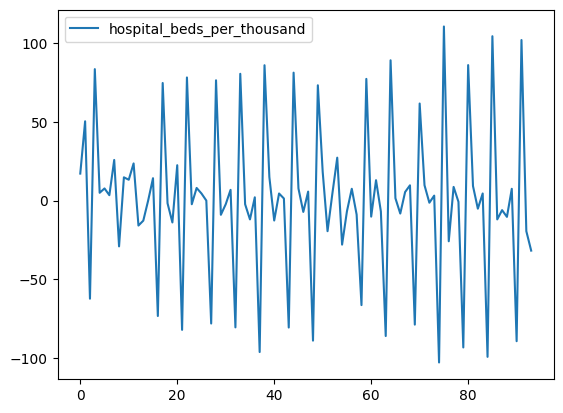

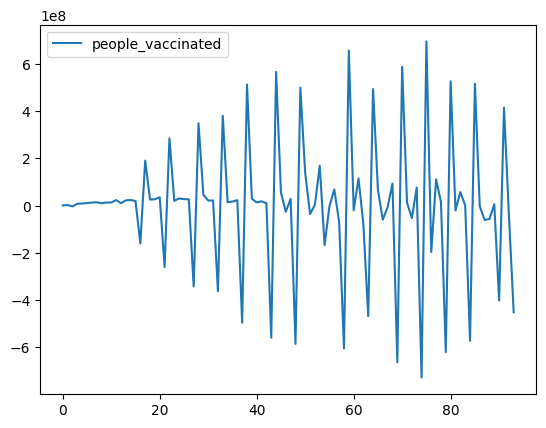

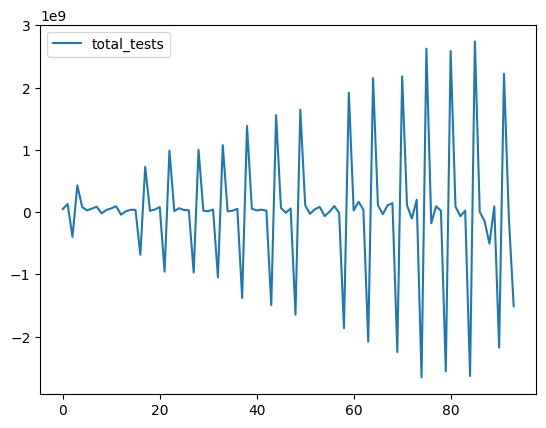

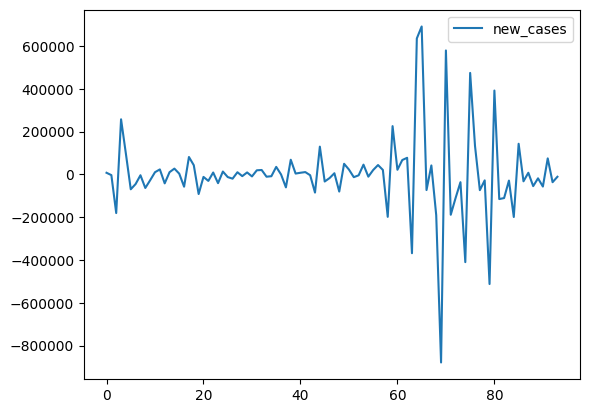

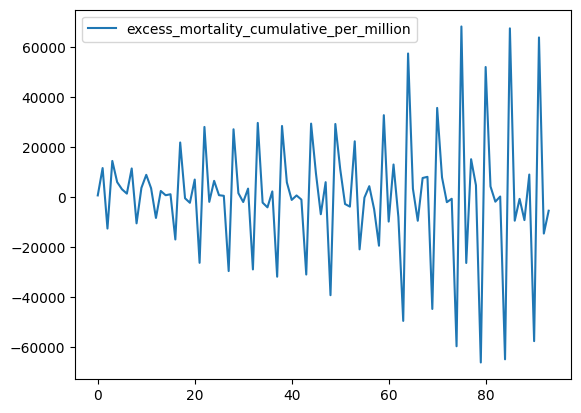

In [13]:
# trend subtraction using differences
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        
    return pd.Series(diff)

diff_df = pd.DataFrame()

for var in all_vars:
    diff_df[var] = difference(merged[var], interval=1)
    diff_df.plot(y=var)

diff_df.fillna(value=0, inplace=True)

# diff = difference(dataset=merged['hospital_beds_per_thousand'], interval=1)

# plt.plot(diff)
# plt.show()

In [14]:
# find the trend
def trendline(data, order=9):
    # polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

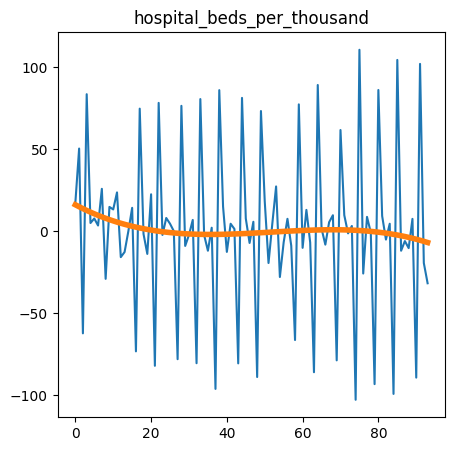

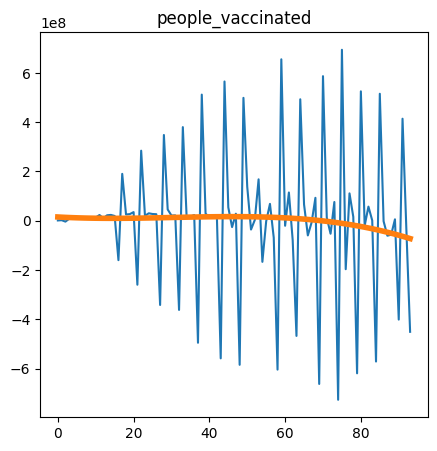

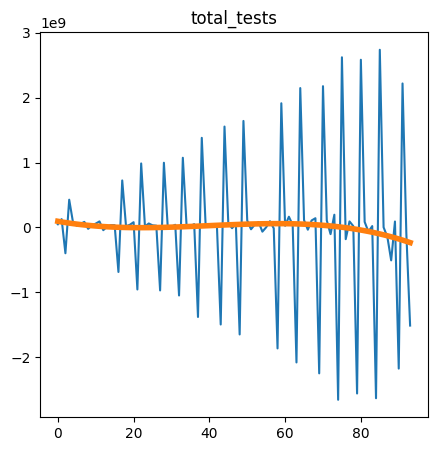

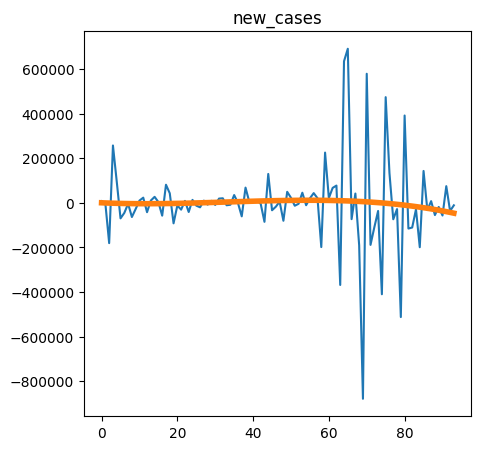

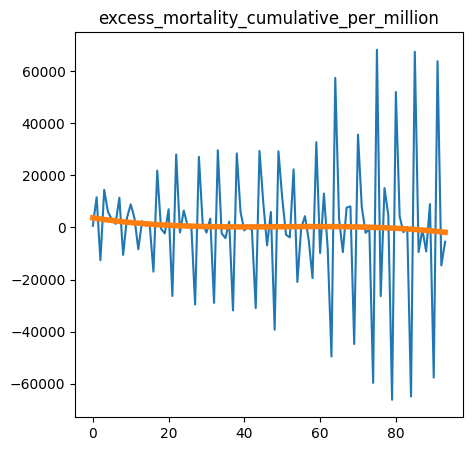

In [35]:
trendless_data = pd.DataFrame()

for var in all_vars:
    trend = trendline(diff_df[var], 3)
    plt.figure(figsize=(5, 5))
    plt.title(var)
    plt.plot(diff_df[var])
    plt.plot(trend, linewidth=4)
    plt.show()
    trendless_data[var] = diff_df[var] - trend
    #trendless_data.plot(y=var)

## 3

<AxesSubplot: >

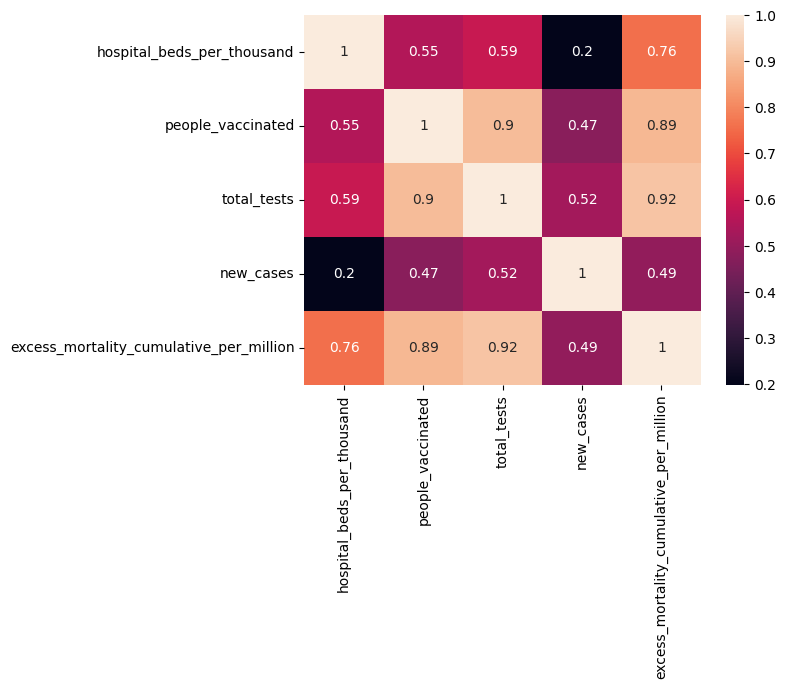

In [16]:
import seaborn as sns
sns.heatmap(merged.corr(method='pearson'), annot=True)

<AxesSubplot: >

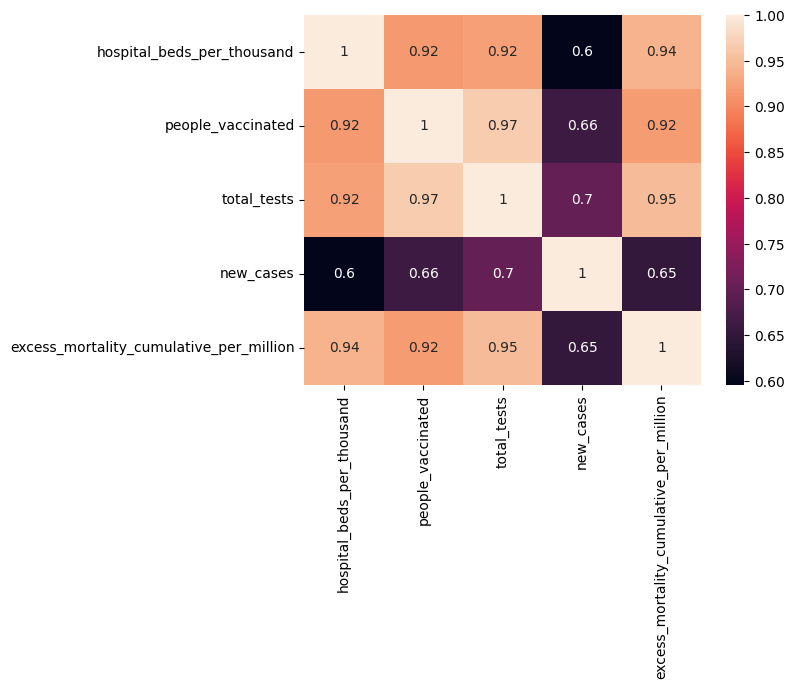

In [17]:
sns.heatmap(diff_df.corr(method='pearson'), annot=True)

<AxesSubplot: >

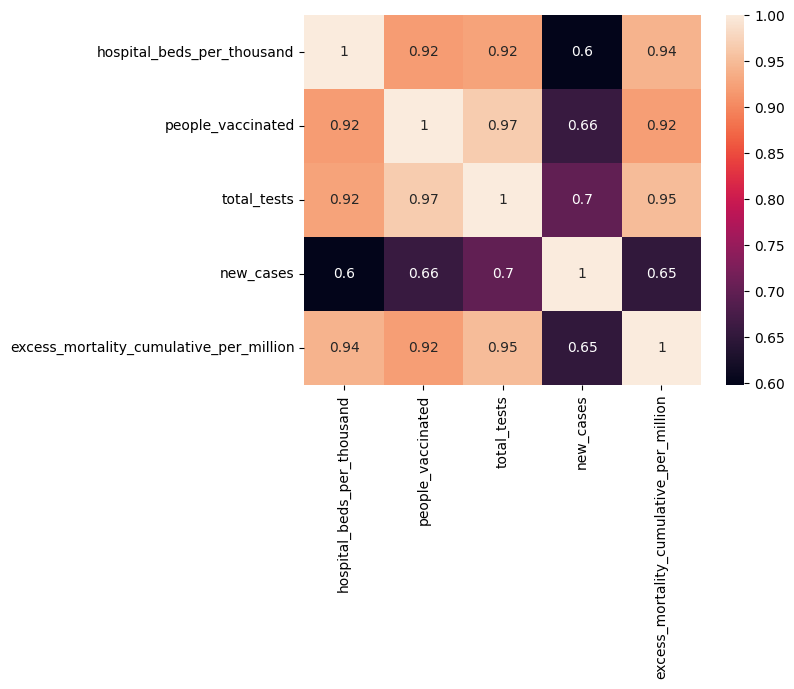

In [18]:
sns.heatmap(trendless_data.corr(method='pearson'), annot=True)

## 4

In [19]:
filter1 = lambda x: x.rolling(window=24, win_type='gaussian', min_periods=1, center=True).mean(std=1)
filter2 = lambda x: x.rolling(window=12, win_type='hamming', min_periods=1, center=True).mean()

def plot_target_filtered(series, var):
    plt.plot(series, label='Truth')
    plt.plot(filter1(series), label='Filter 1')
    plt.plot(filter2(series), label='Filter 2')
    plt.title(var)
    plt.legend()
    plt.show()

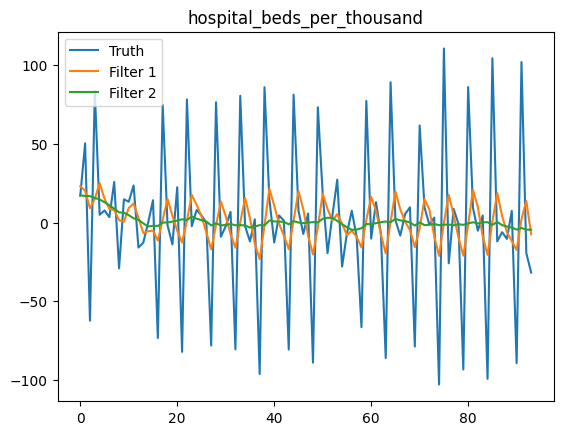

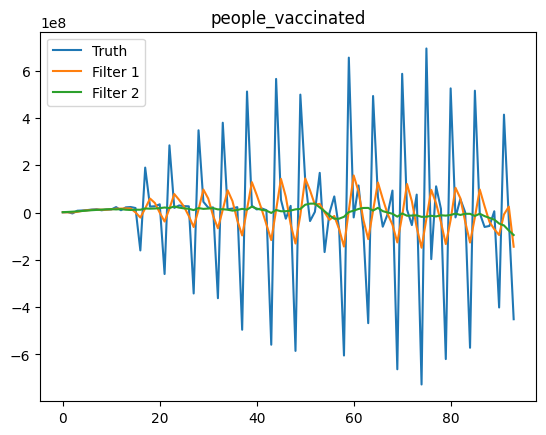

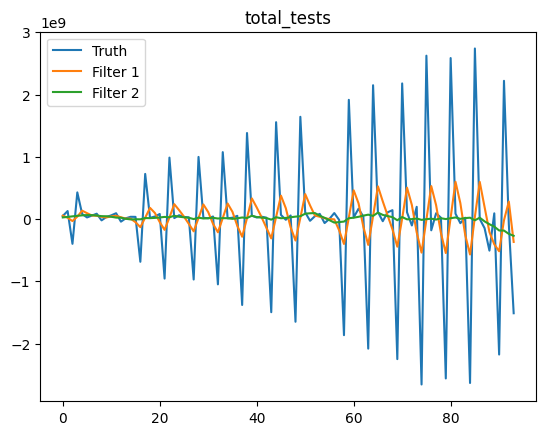

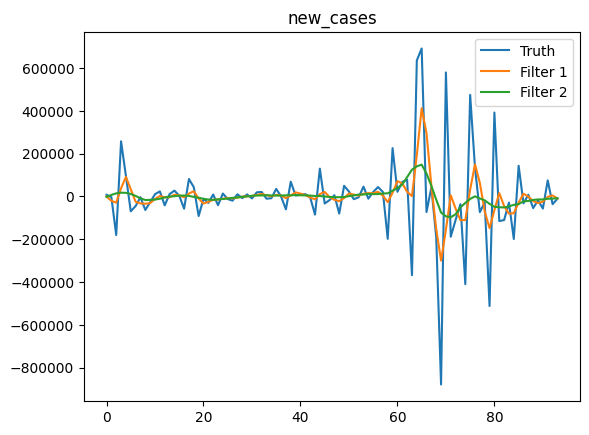

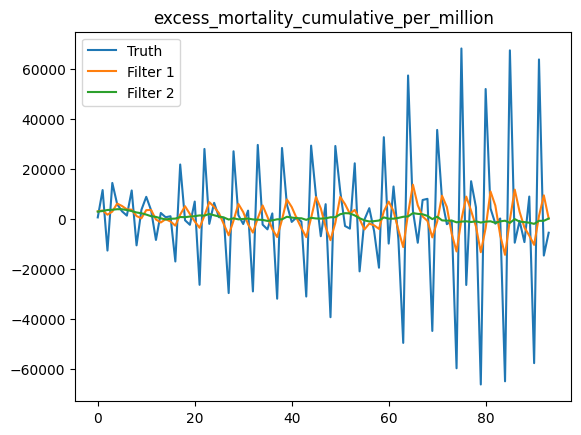

In [20]:
for var in all_vars:
    plot_target_filtered(diff_df[var], var)

## 5

In [21]:
from scipy import signal

def plot_spectral_density(data, var, scaling = 'spectrum'):
    (f, S) = signal.welch(data, scaling = scaling)
    (f_1, S_1) = signal.welch(filter1(data), scaling = scaling)
    (f_2, S_2) = signal.welch(filter2(data), scaling = scaling)
    
    plt.semilogy(f, S, label='Truth')
    plt.semilogy(f_1, S_1, label='Filter 1')
    plt.semilogy(f_2, S_2, label='Filter 2')
    plt.title('Spectral density for ' + var)
    plt.legend()
    plt.show()

d:\Python-3.9.13\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 95, using nperseg = 95
  warnings.warn('nperseg = {0:d} is greater than input length '


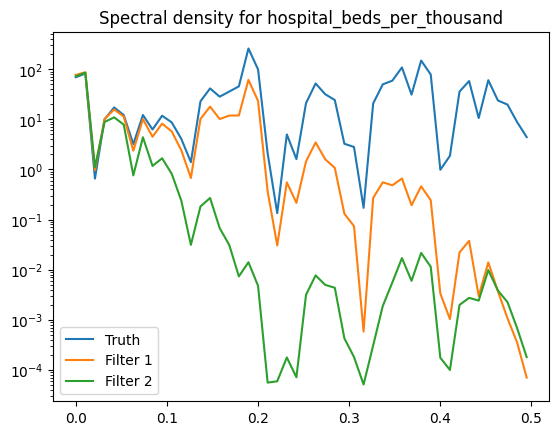

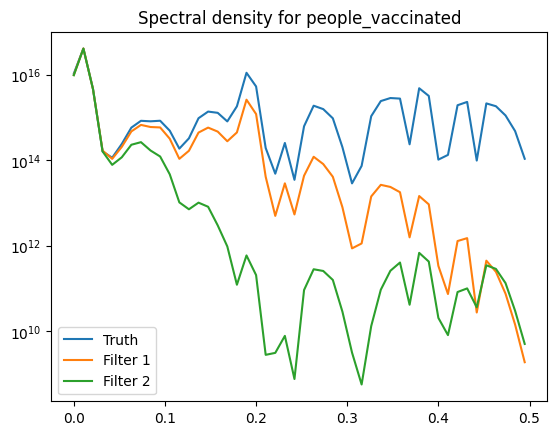

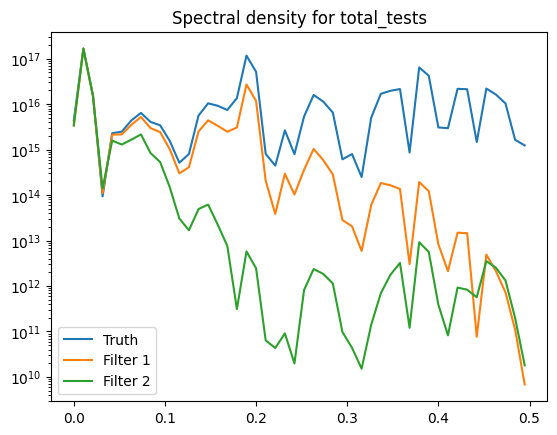

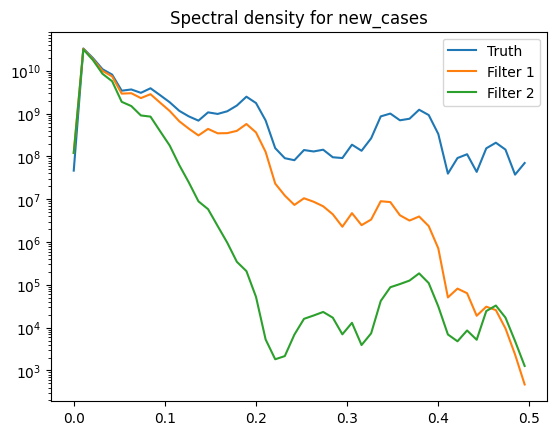

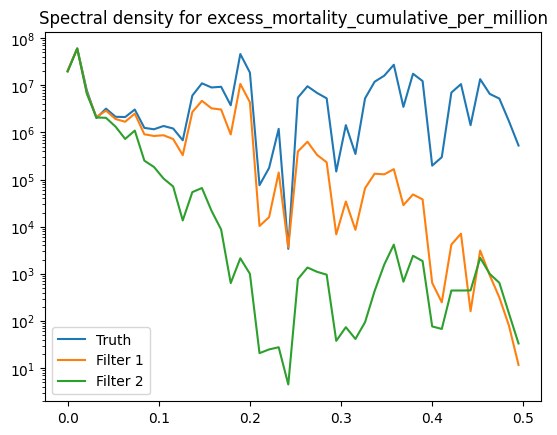

In [22]:
for var in all_vars:
    plot_spectral_density(merged[var], var)

## 6
### Non-Filtered Data

In [29]:
def arima_fit(data):
    time_series = np.array(data)

    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=25))

    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)

    train, test = train_test_data_setup(input_data)

    pipeline = Pipeline(PrimaryNode('arima'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=train,
                                            iterations=100, timeout=5,
                                            cv_folds=2, validation_blocks=2)

    return train, test, pipeline, input_data

def mean_absolute_percentage_error(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3)

Start pipeline tuning
Hyperparameters optimization start
Time series length too small for cross validation with 2 folds. Perform one fold validation
100%|██████████| 100/100 [00:46<00:00,  2.15trial/s, best loss: 260689.92181128255]
Time series length too small for cross validation with 2 folds. Perform one fold validation
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 260689.922 equal or smaller than initial (+ 5% deviation) 279011.002
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


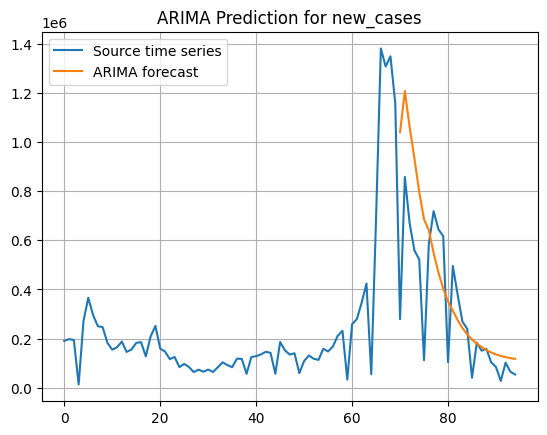

[279021. 857883. 669074. 558811. 522146. 111832. 585722. 718844. 644868.
 616663. 104044. 495606. 380007. 269120. 239908.  40545. 183343. 150745.
 158107. 103032.  84307.  27210. 101789.  65042.  53684.]
[1040451.91646498 1207799.57113005 1060480.3279695   933182.08125603
  796198.37666152  685560.57984916  640515.41803631  548314.2643808
  469184.50041312  403966.4260139   350630.82920538  313939.04846495
  275510.70560848  243194.31763623  217393.35801177  196227.06860206
  180055.49384974  165350.90271706  153099.49133116  143388.65168395
  135525.55085804  129469.99846993  124376.8261092   120373.05103024
  117488.54542681]
-0.044
66430885780.92
100.806


In [30]:
var = 'new_cases'

train, test, pipeline, input_data = arima_fit(merged[var])

fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.title('ARIMA Prediction for ' + var)
plt.grid()
plt.legend()
plt.show()

print(input_data.target[-(len(np.ravel(forecast.predict))):])
print(np.ravel(forecast.predict))

print(round(r2_score(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_squared_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_absolute_percentage_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))

Start pipeline tuning
Hyperparameters optimization start
Time series length too small for cross validation with 2 folds. Perform one fold validation
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]Time series length too small for cross validation with 2 folds. Perform one fold validation
Time series length too small for cross validation with 2 folds. Perform one fold validation
  5%|▌         | 5/100 [00:01<00:22,  4.26trial/s, best loss: 14386.882259934517]Time series length too small for cross validation with 2 folds. Perform one fold validation
Time series length too small for cross validation with 2 folds. Perform one fold validation
 10%|█         | 10/100 [00:02<00:21,  4.28trial/s, best loss: 14386.882259934517]Time series length too small for cross validation with 2 folds. Perform one fold validation
Time series length too small for cross validation with 2 folds. Perform one fold validation
 12%|█▏        | 12/100 [00:02<00:17,  5.05trial/s, best loss: 14386.882259934517

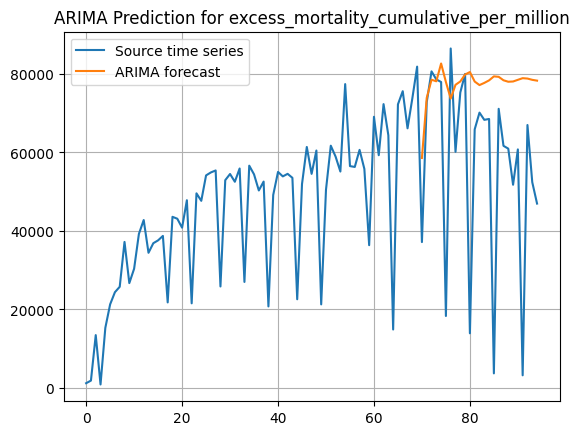

-0.737
969402201.428
227.517


In [31]:
var = 'excess_mortality_cumulative_per_million'

train, test, pipeline, input_data = arima_fit(merged[var])

fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.title('ARIMA Prediction for ' + var)
plt.grid()
plt.legend()
plt.show()

print(round(r2_score(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_squared_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_absolute_percentage_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))

### Filtered Data

Start pipeline tuning
Hyperparameters optimization start
Time series length too small for cross validation with 2 folds. Perform one fold validation
100%|██████████| 100/100 [00:38<00:00,  2.60trial/s, best loss: 177501.89408458502]
Time series length too small for cross validation with 2 folds. Perform one fold validation
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 177501.894 equal or smaller than initial (+ 5% deviation) 205330.497
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


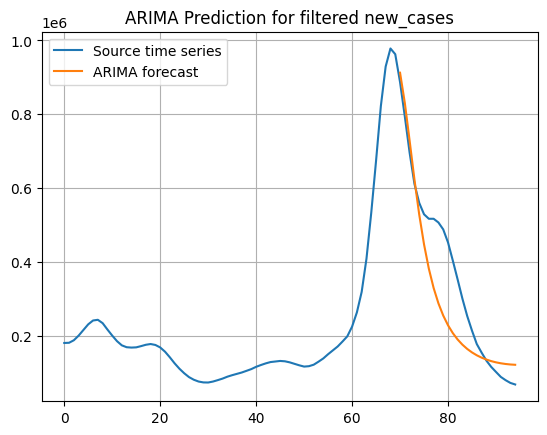

0.774
12747671177.288
29.681


In [32]:
var = 'new_cases'

train, test, pipeline, input_data = arima_fit(filter2(merged[var]))

fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.title('ARIMA Prediction for filtered ' + var)
plt.grid()
plt.legend()
plt.show()

print(round(r2_score(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_squared_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_absolute_percentage_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))

Start pipeline tuning
Hyperparameters optimization start
Time series length too small for cross validation with 2 folds. Perform one fold validation
 39%|███▉      | 39/100 [00:13<00:20,  2.97trial/s, best loss: 8156.4283816770685]Time series length too small for cross validation with 2 folds. Perform one fold validation
Time series length too small for cross validation with 2 folds. Perform one fold validation
 95%|█████████▌| 95/100 [00:33<00:02,  2.10trial/s, best loss: 7679.8333988086015]Time series length too small for cross validation with 2 folds. Perform one fold validation
Time series length too small for cross validation with 2 folds. Perform one fold validation
100%|██████████| 100/100 [00:34<00:00,  2.87trial/s, best loss: 7679.8333988086015]
Time series length too small for cross validation with 2 folds. Perform one fold validation
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 7679.833 equal or smaller than initial (+ 5% d

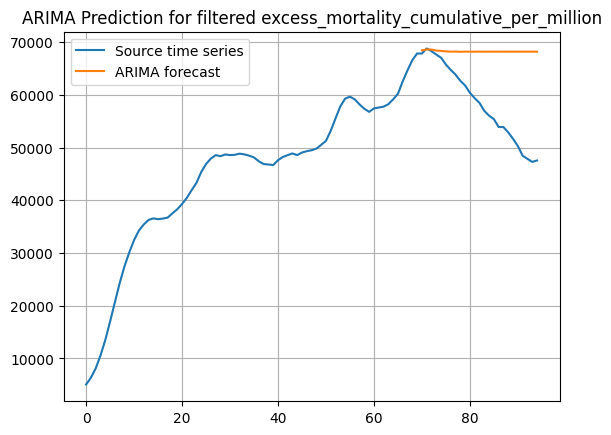

-1.919
147657374.35
18.783


In [33]:
var = 'excess_mortality_cumulative_per_million'

train, test, pipeline, input_data = arima_fit(filter2(merged[var]))

fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.title('ARIMA Prediction for filtered ' + var)
plt.grid()
plt.legend()
plt.show()

print(round(r2_score(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_squared_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))
print(round(mean_absolute_percentage_error(input_data.target[-(len(np.ravel(forecast.predict))):], np.ravel(forecast.predict)), 3))